In [2]:
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
import numpy as np

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
from gazelle.model import GazeLLE
from gazelle.backbone import DinoV2Backbone

backbone_s14 = DinoV2Backbone("dinov2_vits14")
print(f"Created DinoV2Backbone with 'dinov2_vits14'. Pretrained DINOv2 weights for backbone are loaded via torch.hub.")

# 2. GazeLLE 모델을 s14 백본으로 직접 초기화
# GazeLLE의 다른 파라미터는 기본값을 사용합니다.
# (이는 gazelle_dinov2_vitb14() 또는 gazelle_dinov2_vits14() 함수가 GazeLLE를 인스턴스화하는 방식과 동일합니다.)
# inout=False가 GazeLLE의 기본값입니다.
model = GazeLLE(backbone=backbone_s14) 
print(f"GazeLLE model initialized with '{backbone_s14.model}' backbone.")

# 3. 변환(transform)은 생성된 s14 백본에서 가져오기
# GazeLLE 모델은 일반적으로 (448, 448) 크기의 입력을 기대합니다.
transform = backbone_s14.get_transform(in_size=(448, 448))

model.eval()
model.to(device)

Using cache found in /Users/ggrrm/.cache/torch/hub/facebookresearch_dinov2_main


Created DinoV2Backbone with 'dinov2_vits14'. Pretrained DINOv2 weights for backbone are loaded via torch.hub.
GazeLLE model initialized with 'DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features

GazeLLE(
  (backbone): DinoV2Backbone(
    (model): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=384, out_features=1152, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=384, out_features=384, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=384, out_features=1536, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=1536, out_features=384, bias

In [19]:
# 4. GazeLLE 헤드 가중치를 'gazelle_dinov2_vitb14' 모델로부터 가져와 로드
# torch.hub.load를 사용하여 'fkryan/gazelle' 저장소에서 'gazelle_dinov2_vitb14' 모델을 로드합니다.
# 이 pretrained_b14_model은 dinov2_vitb14 백본과 해당 GazeLLE 헤드 가중치를 모두 포함합니다.
try:
    print("Attempting to load 'gazelle_dinov2_vitb14' from torch.hub to extract GazeLLE head weights...")
    
    # 'fkryan/gazelle' 저장소에서 'gazelle_dinov2_vitb14' 모델 (가중치 포함)을 로드합니다.
    # 이 함수는 모델과 변환(transform)을 반환하므로, 모델만 받습니다.
    # trust_repo=True는 사용자 정의 코드가 포함된 저장소를 로드할 때 필요할 수 있습니다.
    pretrained_b14_model_for_weights, _ = torch.hub.load(
        'fkryan/gazelle', 
        'gazelle_dinov2_vitb14', # vitb14 아키텍처의 GazeLLE 헤드 가중치를 원함
        force_reload=False,      # 필요시 True로 설정하여 캐시 무시
        trust_repo=True          # GazeLLE 저장소의 코드를 신뢰한다고 명시
    )
    # 가중치 추출 후 메모리에서 바로 해제할 수 있도록 CPU로 옮기거나, 필요 없다면 이 라인 생략 가능
    pretrained_b14_model_for_weights.to('cpu') 

    print(f"Successfully loaded 'gazelle_dinov2_vitb14' (for weights) from torch.hub.")
    print(f"Backbone of this hub-loaded model: {pretrained_b14_model_for_weights.backbone.model}") # dinov2_vitb14 여야 함

    # 로드된 pretrained_b14_model_for_weights의 state_dict에서 GazeLLE 헤드 부분만
    # 현재 로컬로 구성한 model (dinov2_vits14 백본 사용)에 적용합니다.
    # model.load_gazelle_state_dict는 GazeLLE 헤드 관련 키만 업데이트합니다.
    # include_backbone=False를 명시하여 pretrained_b14_model_for_weights의 백본(dinov2_vitb14) 가중치가
    # 현재 model의 백본(dinov2_vits14)을 덮어쓰지 않도록 합니다.
    model.load_gazelle_state_dict(pretrained_b14_model_for_weights.state_dict(), include_backbone=False)
    
    print("GazeLLE head weights (extracted from 'gazelle_dinov2_vitb14' hub model) loaded successfully onto the current model (with s14 backbone).")
    print("WARNING: Using GazeLLE head weights potentially trained for a 'dinov2_vitb14' backbone with a 'dinov2_vits14' backbone. Compatibility and performance may vary.")

    # 가중치 추출에 사용된 모델은 더 이상 필요 없으므로 메모리에서 명시적으로 삭제 (선택 사항)
    del pretrained_b14_model_for_weights

except Exception as e:
    print(f"Error loading 'gazelle_dinov2_vitb14' from torch.hub or applying its GazeLLE head weights: {e}")
    print("Please ensure the 'fkryan/gazelle' hub repository and the 'gazelle_dinov2_vitb14' model entry are accessible and correctly defined in its hubconf.py.")
    print("Proceeding with an uninitialized GazeLLE head (the DINOv2 s14 backbone itself is pretrained).")


Attempting to load 'gazelle_dinov2_vitb14' from torch.hub to extract GazeLLE head weights...


Using cache found in /Users/ggrrm/.cache/torch/hub/fkryan_gazelle_main
Using cache found in /Users/ggrrm/.cache/torch/hub/facebookresearch_dinov2_main


Successfully loaded 'gazelle_dinov2_vitb14' (for weights) from torch.hub.
Backbone of this hub-loaded model: DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): 

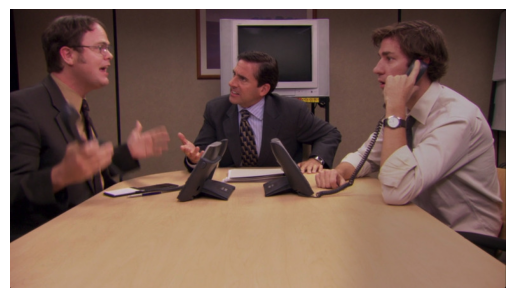

In [6]:
# load an input image

image_url = "https://www.looper.com/img/gallery/the-office-funniest-moments-ranked/jim-and-dwights-customer-service-training-1627594561.jpg"
# image_url = "https://ew.com/thmb/n5b8Asz4Y5Lp0sSEF7WgS-ESyFc=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/succession-finale-052923-ec304aabcbf24a7b9fad891a87f49b74.jpg"
# image_url = "https://i.kym-cdn.com/entries/icons/original/000/045/575/blackcatzoningout_meme.jpg"

try:
    response = requests.get(image_url, stream=True)
    response.raise_for_status()

    image = Image.open(BytesIO(response.content))
    width, height = image.size

    plt.imshow(image)
    plt.axis('off')
    plt.show()

except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")

In [8]:
from facenet_pytorch import MTCNN
import numpy as np

# initialize once (on GPU if available)
mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

# detect
boxes, probs = mtcnn.detect(np.array(image))

# boxes is an N×4 array of [x1, y1, x2, y2]
print(boxes)


[[571.8992309570312 41.866554260253906 632.849365234375
  140.00265502929688]
 [107.4179916381836 28.080219268798828 160.64881896972656
  117.36040496826172]
 [343.9955139160156 80.08536529541016 391.2337646484375
  149.66619873046875]]


In [10]:
# prepare gazelle input
img_tensor = transform(image).unsqueeze(0).to(device)
norm_bboxes = [[np.array(bbox) / np.array([width, height, width, height]) for bbox in boxes]]

input = {
    "images": img_tensor, # [num_images, 3, 448, 448]
    "bboxes": norm_bboxes # [[img1_bbox1, img1_bbox2...], [img2_bbox1, img2_bbox2]...]
}

with torch.no_grad():
    output = model(input)

img1_person1_heatmap = output['heatmap'][0][0] # [64, 64] heatmap
print(img1_person1_heatmap.shape)
if model.inout:
  img1_person1_inout = output['inout'][0][0] # gaze in frame score (if model supports inout prediction)
  print(img1_person1_inout.item())


torch.Size([64, 64])
0.9495943188667297


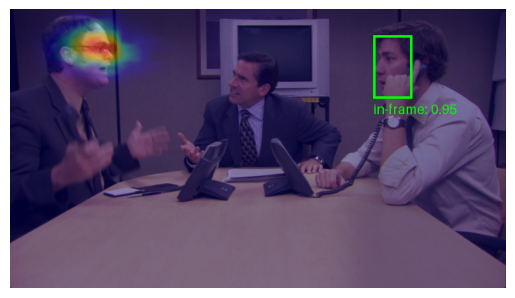

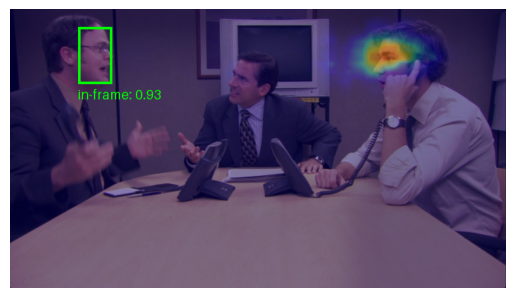

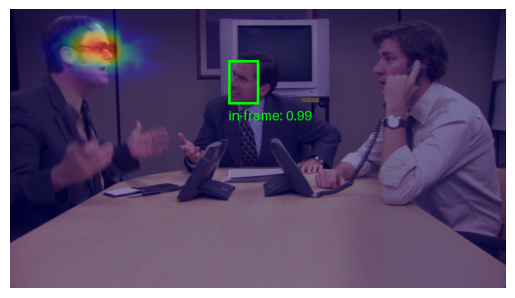

In [11]:
# visualize predicted gaze heatmap for each person and gaze in/out of frame score

def visualize_heatmap(pil_image, heatmap, bbox=None, inout_score=None):
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.detach().cpu().numpy()
    heatmap = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(pil_image.size, Image.Resampling.BILINEAR)
    heatmap = plt.cm.jet(np.array(heatmap) / 255.)
    heatmap = (heatmap[:, :, :3] * 255).astype(np.uint8)
    heatmap = Image.fromarray(heatmap).convert("RGBA")
    heatmap.putalpha(90)
    overlay_image = Image.alpha_composite(pil_image.convert("RGBA"), heatmap)

    if bbox is not None:
        width, height = pil_image.size
        xmin, ymin, xmax, ymax = bbox
        draw = ImageDraw.Draw(overlay_image)
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline="lime", width=int(min(width, height) * 0.01))

        if inout_score is not None:
          text = f"in-frame: {inout_score:.2f}"
          text_width = draw.textlength(text)
          text_height = int(height * 0.01)
          text_x = xmin * width
          text_y = ymax * height + text_height
          draw.text((text_x, text_y), text, fill="lime", font=ImageFont.load_default(size=int(min(width, height) * 0.05)))
    return overlay_image

for i in range(len(boxes)):
  plt.figure()
  plt.imshow(visualize_heatmap(image, output['heatmap'][0][i], norm_bboxes[0][i], inout_score=output['inout'][0][i] if output['inout'] is not None else None))
  plt.axis('off')
  plt.show()



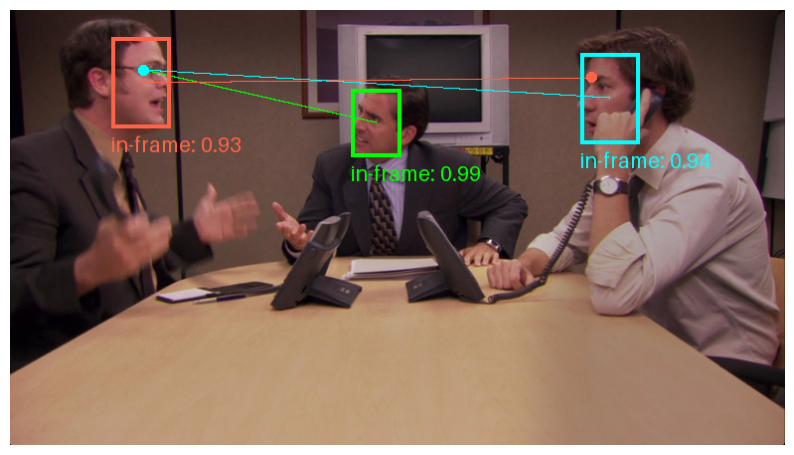

In [ ]:
# combined visualization with maximal gaze points for each person

def visualize_all(pil_image, heatmaps, bboxes, inout_scores, inout_thresh=0.5):
    colors = ['lime', 'tomato', 'cyan', 'fuchsia', 'yellow']
    overlay_image = pil_image.convert("RGBA")
    draw = ImageDraw.Draw(overlay_image)
    width, height = pil_image.size

    for i in range(len(bboxes)):
        bbox = bboxes[i]
        xmin, ymin, xmax, ymax = bbox
        color = colors[i % len(colors)]
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline=color, width=int(min(width, height) * 0.01))

        if inout_scores is not None:
            inout_score = inout_scores[i]
            text = f"in-frame: {inout_score:.2f}"
            text_width = draw.textlength(text)
            text_height = int(height * 0.01)
            text_x = xmin * width
            text_y = ymax * height + text_height
            draw.text((text_x, text_y), text, fill=color, font=ImageFont.load_default(size=int(min(width, height) * 0.05)))

        if inout_scores is not None and inout_score > inout_thresh:
            heatmap = heatmaps[i]
            heatmap_np = heatmap.detach().cpu().numpy()
            max_index = np.unravel_index(np.argmax(heatmap_np), heatmap_np.shape)
            gaze_target_x = max_index[1] / heatmap_np.shape[1] * width
            gaze_target_y = max_index[0] / heatmap_np.shape[0] * height
            bbox_center_x = ((xmin + xmax) / 2) * width
            bbox_center_y = ((ymin + ymax) / 2) * height

            draw.ellipse([(gaze_target_x-5, gaze_target_y-5), (gaze_target_x+5, gaze_target_y+5)], fill=color, width=int(0.005*min(width, height)))
            draw.line([(bbox_center_x, bbox_center_y), (gaze_target_x, gaze_target_y)], fill=color, width=int(0.005*min(width, height)))

    return overlay_image

plt.figure(figsize=(10,10))
plt.imshow(visualize_all(image, output['heatmap'][0], norm_bboxes[0], output['inout'][0] if output['inout'] is not None else None, inout_thresh=0.5))
plt.axis('off')
plt.show()